In [1]:
import numpy as np
import json
import os
import pycolmap
import shutil
from pyquaternion import Quaternion
from pathlib import Path

from hloc.triangulation import create_db_from_model
from hloc.utils.read_write_model import Camera, Image, Point3D, CAMERA_MODEL_NAMES
from hloc.utils.read_write_model import write_model, read_model
from hloc import extract_features, match_features, pairs_from_poses, triangulation
from hloc import visualization
from hloc.visualization import plot_images, read_image

In [2]:
from scipy.spatial.transform import Rotation
def convert_vec_to_matrix(vec_p, vec_q, mode='xyzw'):
	# Initialize a 4x4 identity matrix
	tf = np.eye(4)
	if mode == 'xyzw':
		# Set the rotation part of the transformation matrix using the quaternion
		tf[:3, :3] = Rotation.from_quat(vec_q).as_matrix()
		# Set the translation part of the transformation matrix
		tf[:3, 3] = vec_p
	elif mode == 'wxyz':
		# Set the rotation part of the transformation matrix using the quaternion
		tf[:3, :3] = Rotation.from_quat(np.roll(vec_q, -1)).as_matrix()
		# Set the translation part of the transformation matrix
		tf[:3, 3] = vec_p
	return tf
def convert_matrix_to_vec(tf_matrix, mode='xyzw'):
	if mode == 'xyzw':
		# Extract the translation vector from the matrix
		vec_p = tf_matrix[:3, 3]
		# Extract the rotation part of the matrix and convert it to a quaternion
		vec_q = Rotation.from_matrix(tf_matrix[:3, :3]).as_quat()
	if mode == 'wxyz':
		# Extract the translation vector from the matrix
		vec_p = tf_matrix[:3, 3]
		# Extract the rotation part of the matrix and convert it to a quaternion
		vec_q = np.roll(Rotation.from_matrix(tf_matrix[:3, :3]).as_quat(), 1)
	return vec_p, vec_q

20 mapping images
Writing the COLMAP model...


({0: Camera(id=0, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  1: Camera(id=1, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  2: Camera(id=2, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  3: Camera(id=3, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  4: Camera(id=4, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  5: Camera(id=5, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  6: Camera(id=6, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  7: Camera(id=7, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  8: Camera(id=8, model='PINHOLE', width=640, height=360, params=[205.46963, 205.46963, 320.0, 180.0]),
  9: Camera(id=9, model='PINHOLE', width=640, height=360, params

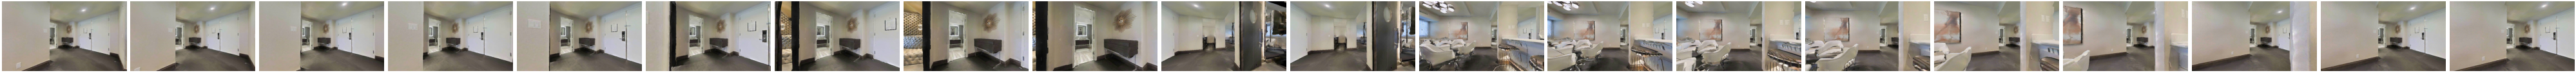

In [3]:
data_path = '/Rocket_ssd/dataset/data_litevloc/matterport3d/map_free_eval/test/s00000/'
images = Path(data_path)
outputs = Path("outputs_colmap")
!rm -rf $outputs
sfm_pairs = outputs / "pairs-sfm.txt"
loc_pairs = outputs / "pairs-loc.txt"
sfm_dir = outputs / "sfm"
features = outputs / "features.h5"
matches = outputs / "matches.h5"


##### Load Iamges
references = [f'seq1/frame_{i:05}.jpg' for i in range(20)]
print(len(references), "mapping images")
plot_images([read_image(images / r) for r in references], dpi=25)

##### Load Poses and Intrinsics
poses = {}
with (images / 'poses.txt').open('r') as f:
    for line in f.readlines():
        if '#' in line: continue
        line = line.strip().split(' ')
        img_name = line[0]
        qwxyz, txyz = np.array(list(map(float, line[1:5]))), np.array(list(map(float, line[5:])))
        T_c2w = convert_vec_to_matrix(txyz, qwxyz, mode='wxyz')
        T_w2c = np.linalg.inv(T_c2w)
        txyz, qwxyz = convert_matrix_to_vec(T_w2c, mode='wxyz')
        poses[img_name] = (qwxyz, txyz)

intrinsics = {}
with (images / 'intrinsics.txt').open('r') as f:
    for line in f.readlines():
        if '#' in line: continue
        line = line.strip().split(' ')
        img_name = line[0]
        fx, fy, cx, cy, width, height = float(line[1]), float(line[2]), float(line[3]), float(line[4]), float(line[5]), float(line[6])
        intrinsics[img_name] = (fx, fy, cx, cy, width, height)

##### Create Image Objects
images = {}
cameras = {}
for idx, ref_img in enumerate(references):
    qwxyz, txyz = poses[ref_img]
    intrinsic = intrinsics[ref_img]
    image = Image(
        id=idx,
        qvec=np.roll(qwxyz, -1),
        tvec=txyz,
        camera_id=idx,
        name=ref_img,
        xys=[],
        point3D_ids=[]
    )
    images[idx] = image
    
    fx, fy, cx, cy, width, height = intrinsic
    camera = Camera(
        id=idx, model='PINHOLE', 
        width=int(width), height=int(height), 
        params=[fx, fy, cx, cy]
    )
    cameras[idx] = camera

points3D = {}
print('Writing the COLMAP model...')
colmap_arkit = outputs / 'colmap_arkit'
colmap_arkit.mkdir(exist_ok=True, parents=True)
write_model(images=images, cameras=cameras, points3D=points3D, path=str(colmap_arkit), ext='.bin')


In [10]:
# feature_conf = extract_features.confs["disk"]
# feature_conf['model']['max_keypoints'] = 2048

# matcher_conf = match_features.confs["disk+lightglue"]

# print('feature_conf: ', feature_conf)
# print('matcher_conf: ', matcher_conf)

##### Extract Features
# feature_conf = extract_features.confs['superpoint_aachen']
# matcher_conf = match_features.confs['superglue']
 
feature_conf = extract_features.confs['superpoint_inloc']
matcher_conf = match_features.confs['superglue']
 
extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_poses.main(colmap_arkit, sfm_pairs, len(references))
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches)

# colmap_sparse = outputs / 'colmap_sparse'
# colmap_sparse.mkdir(exist_ok=True, parents=True)
# model = triangulation.main(
#     colmap_sparse,
#     colmap_arkit,
#     images,
#     sfm_pairs,
#     features,
#     matches)

# if model is not None or len(model.points3D) > 500:
#     visualization.visualize_sfm_2d(model, images, color_by="visibility", n=1)
#     cnt = sum(1 for image in model.images.values() if image.num_points3D > 500)
#     print('Successful trianglation:', cnt, '/', len(model.images))
#     print('Number of 3D Points: ', len(model.points3D))
#     for image in model.images.values(): print(image)

[2024/11/18 16:49:33 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 4},
 'output': 'feats-superpoint-n4096-r1600',
 'preprocessing': {'grayscale': True, 'resize_max': 1600}}


TypeError: unsupported operand type(s) for /: 'dict' and 'str'